In [1]:
import pandas as pd
import numpy as np
from data import get_historical_data
import mplfinance as mpf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
stock_df = get_historical_data('2303.TW')

In [3]:
stock_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2000-01-04,23.798928,24.307451,23.392107,24.104042,332630460,0.0,0.0
2000-01-05,23.595513,24.104038,23.392103,24.002335,292754299,0.0,0.0
2000-01-06,24.002333,24.002333,23.392101,23.493809,248928848,0.0,0.0
2000-01-07,22.883581,23.086991,22.171648,22.781878,269228882,0.0,0.0
2000-01-10,21.764833,23.595518,21.764833,23.392107,380487972,0.0,0.0


In [5]:
def trend_slope_strategy(stock_df, pred_days=5, steepness_period=2, m = 3, duration = 100):
    for n in [3, 5, 10, 20]:
        stock_df['ma'+str(n)] = stock_df.Close.rolling(n).mean()

    for d in [1, 3, 5]:
        stock_df[str(d)+'d_future_close'] = stock_df['Close'].shift(-d)
        stock_df[str(d)+'d_close_future_pct'] = stock_df[str(d)+'d_future_close'].pct_change(5)

    slope_indicator = lambda x: (x[-1] - x[-1-steepness_period]) / steepness_period
    stock_df['slope_indicator'] = stock_df['ma'+str(m)].pct_change().rolling(m).apply(slope_indicator)

    def buy_signal(c):
        if c[-1]>0 and c[-2]<0 and c[-3]<0:
            return 1
        else:
            return 0
    
    stock_df['buy_signal'] = stock_df['slope_indicator'].rolling(pred_days).apply(buy_signal)
    stock_df['buy_signal'] = stock_df.apply(lambda x: x['Low']-0.5 if x['buy_signal']==1 else np.nan, axis=1)

    buy_stock_df = stock_df[~stock_df['buy_signal'].isnull()]
    #勝率
    win_rate = np.sum(buy_stock_df[str(pred_days)+'d_close_future_pct']>0)/len(buy_stock_df)
    #平均報酬率
    avg_return = buy_stock_df[str(pred_days)+'d_close_future_pct'].mean()
    #期望報酬
    profit = buy_stock_df[buy_stock_df[str(pred_days)+'d_close_future_pct']>0][str(pred_days)+'d_close_future_pct'].mean()
    #期望虧損
    loss = buy_stock_df[buy_stock_df[str(pred_days)+'d_close_future_pct']<0][str(pred_days)+'d_close_future_pct'].mean()
    #盈虧比
    pl_ratio = abs(profit/loss)
    back_test = pd.DataFrame({'勝率':win_rate,'平均報酬率':avg_return,'期望報酬':profit,'期望虧損':loss,'盈虧比':pl_ratio},index=['回測結果'])
    stock_df[~stock_df['buy_signal'].isnull()]['5d_close_future_pct'].plot.hist(bins=50)
    
    duration = 100
    df = stock_df.iloc[-(duration+m):]
    mc = mpf.make_marketcolors(up='r',
                            down='g',
                            edge='',
                            wick='inherit',
                            volume='inherit')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)
    add_plot =[mpf.make_addplot(df["slope_indicator"],panel= 2,color="b"),
            mpf.make_addplot(df["buy_signal"],scatter=True, markersize=100, marker='^', color='r')]

    mpf.plot(df, type='candle', style=s, volume=True,figsize=(20, 10),mav=(3,),addplot=add_plot)


    return back_test


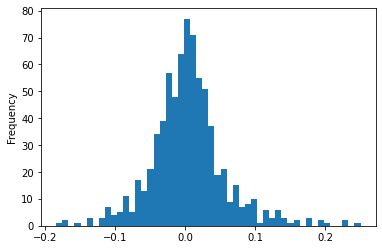

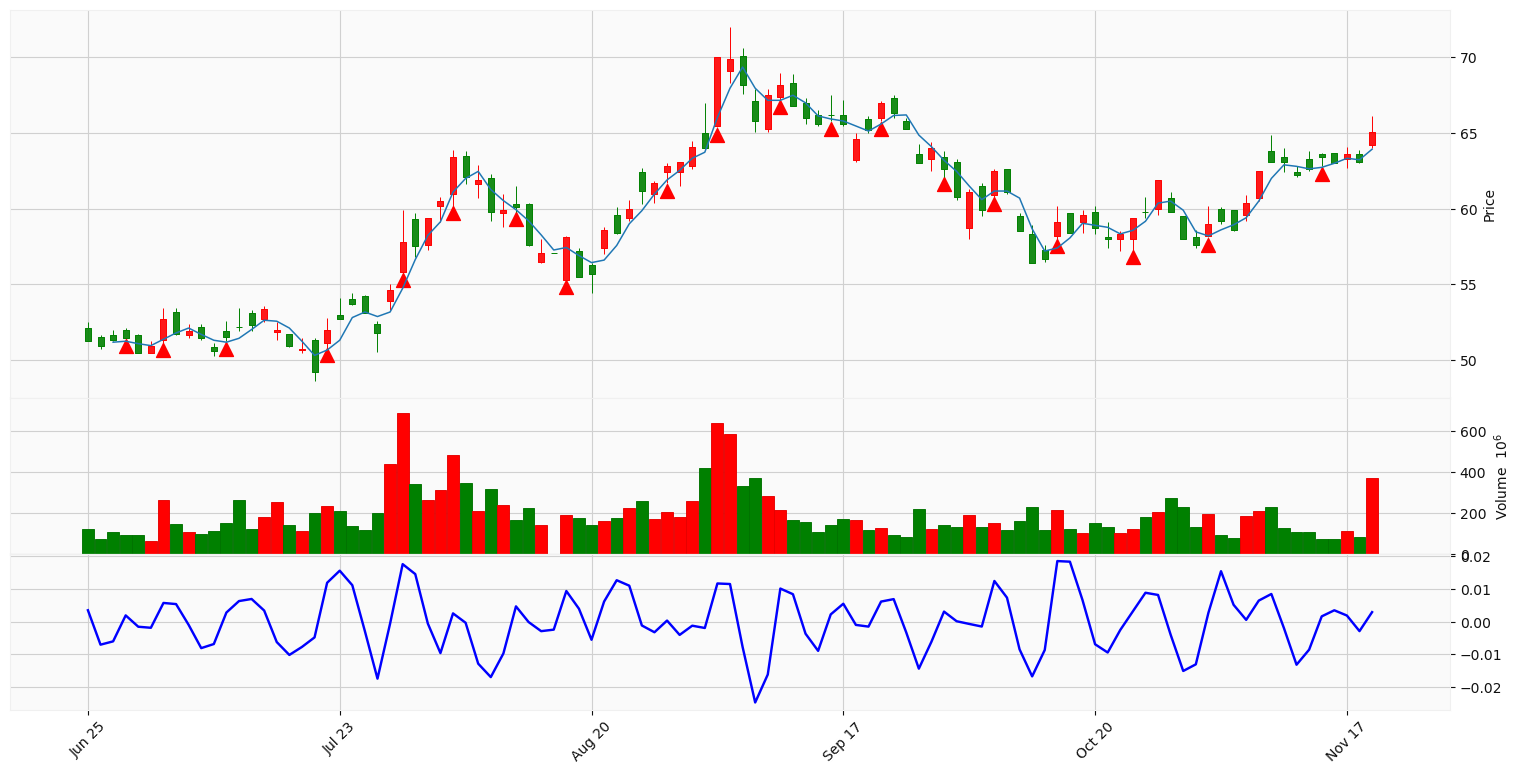

,勝率,平均報酬率,期望報酬,期望虧損,盈虧比
回測結果,0.506702,0.0044,0.041171,-0.036658,1.123128


In [6]:
trend_slope_strategy(stock_df)